## Import

In [1]:
import pandas as pd
import numpy as np

# Use for Labeling
from sklearn.cluster import KMeans

# Predict Test Model
from models.model import Informer

# Visualize Option
import matplotlib.pyplot as plt
import seaborn as sns 
plt.rcParams['font.family'] = 'Malgun Gothic'
import warnings ; warnings.filterwarnings('ignore')

## Read Data
기상청 종관기상관측(ASOS) 데이터로부터 훈련 기간 내 제주특별자치도 기상정보를 추출하고 학습 기간의 데이터를 예측해 외부데이터로 사용하고자 한다. 
- 기상 상태는 교통 흐름을 변화시키고 교통사고로 이어지게 해 교통예측에 중요한 변수이다. 
- 기상청 종관기상관측 데이터는 기상청 관측소에서 시간별로 기온, 강수량 등 기상정보가 측정된 데이터로 제주특별자치도 내 기상청 관측소는 동부의 성산지점(188), 서부의 고산지점(185), 남부의 서귀포지점(189), 북부의 제주지점(184)으로 이루어져 있다. 데이터의 위경도 좌표로 Kmeans Clustering을 한 후 각 지점을 연관시킨다.
- 기상청 지상기상관측지침을 참고하여 관측자의 주관이 개입되지 않은 기상정보 중 기온, 강수량, 풍속, 습도, 증기압, 이슬점온도를 사용한다.

[기상청 종관기상관측 데이터] https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36<br>
[기상청 지상기상관측지침] https://book.kma.go.kr/viewer/MediaViewer.ax?cid=33393&rid=5&moi=5241

In [2]:
train = pd.read_csv('../data/raw/train.csv', parse_dates=['base_date'],
                    usecols=['id','base_date','base_hour','start_latitude','start_longitude','end_latitude','end_longitude'])
test = pd.read_csv('../data/raw/test.csv', parse_dates=['base_date'],
                    usecols=['id','base_date','base_hour','start_latitude','start_longitude','end_latitude','end_longitude'])

In [3]:
kma = pd.read_csv('../data/raw/OBS_ASOS_TIM_20221113145942.csv', parse_dates=['일시'], encoding='cp949')

# 불필요한 열을 삭제한다.
del kma['지점']

# 컬럼명의 특수기호를 삭제한다.
kma.columns = kma.columns.map(lambda x: x if x.find('(') == -1 else x[:x.find('(')])

In [4]:
# 지점별 데이터로 분리한다.
date = pd.date_range('20190801 00:00','20220731 23:00',freq='H') ; print('데이터수:', date.shape[0])
jeju = pd.merge(pd.DataFrame({'일시':date}), kma.query('지점명=="제주"'), on='일시', how='left')
gosan = pd.merge(pd.DataFrame({'일시':date}), kma.query('지점명=="고산"'), on='일시', how='left')
sungsan = pd.merge(pd.DataFrame({'일시':date}), kma.query('지점명=="성산"'), on='일시', how='left')
seogwipo = pd.merge(pd.DataFrame({'일시':date}), kma.query('지점명=="서귀포"'), on='일시', how='left')

데이터수: 26304


### Data Cleansing

In [5]:
# 데이터 내 결측이 존재한다.
print('성산점 평균 결측비율:', (sungsan.isna().sum()/sungsan.shape[0]).mean())
print('고산점 평균 결측비율:', (gosan.isna().sum()/gosan.shape[0]).mean())
print('서귀포점 평균 결측비율:', (seogwipo.isna().sum()/seogwipo.shape[0]).mean())
print('제주점 평균 결측비율:', (jeju.isna().sum()/jeju.shape[0]).mean())

성산점 평균 결측비율: 0.6492802108678022
고산점 평균 결측비율: 0.6491365909705327
서귀포점 평균 결측비율: 0.6486930589348474
제주점 평균 결측비율: 0.6487353000811031


In [6]:
# 강수량 결측은 0으로 채운다.
sungsan['강수량'].fillna(0, inplace=True)
gosan['강수량'].fillna(0, inplace=True)
seogwipo['강수량'].fillna(0, inplace=True)
jeju['강수량'].fillna(0, inplace=True)

In [7]:
# 데이터 내 결측을 최근 3일의 동시간대 데이터 평균으로 채운다.
def mean_threeday(DATA):
    for COL in range(DATA.shape[1]):
        if DATA.iloc[:,COL].isna().sum() > 0:
            for INDEX in DATA[DATA.iloc[:,COL].isna()].index.values:
                DATA.iloc[INDEX, COL] = kma.iloc[[INDEX-72,INDEX-48,INDEX-24], COL].mean()
    return DATA

In [8]:
clean_jeju = mean_threeday(jeju)
clean_gosan = mean_threeday(gosan)
clean_sungsan = mean_threeday(sungsan)
clean_seogwipo = mean_threeday(seogwipo)

### Generate Cluster Label
- Kmeans Cluster는 방대한 데이터에 대해 빠르게 처리하며 Cluster의 개수를 지정할 수 있다.

In [9]:
cluster = KMeans(n_clusters=4, random_state=2022).fit(np.vstack((train[['start_latitude','start_longitude']].values, 
                                                                 train[['end_latitude','end_longitude']].values)))
train['start_cluster'] = cluster.predict(train[['start_latitude','start_longitude']].values)
train['end_cluster'] = cluster.predict(train[['end_latitude','end_longitude']].values)
test['start_cluster'] = cluster.predict(test[['start_latitude','start_longitude']].values)
test['end_cluster'] = cluster.predict(test[['end_latitude','end_longitude']].values)

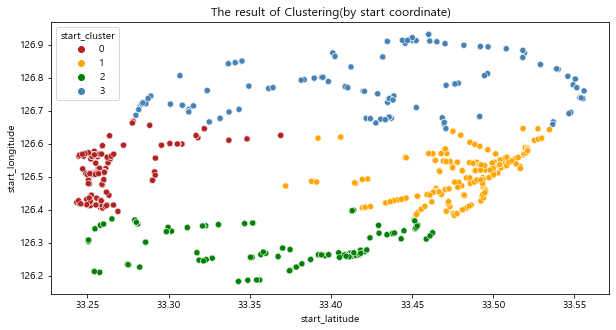

In [10]:
# 각 클러스터가 어느 기상관측지점과 가까울 지 보기 위해 출발 위경도 좌표로 scatterplot을 그려본다.
# 0번은 '고산', 1번은 '성산', 2번은 '서귀포', 3번은 '제주'로 봐도 무방함을 확인하였다.
plt.figure(figsize=(10,5))
sns.scatterplot(data=train[['start_latitude','start_longitude','start_cluster']], 
                x='start_latitude',y='start_longitude',hue='start_cluster',
                palette=['firebrick','orange','green','steelblue'])
plt.title("The result of Clustering(by start coordinate)")
plt.show()

In [11]:
label = {0:'고산',1:'성산',2:'서귀포',3:'제주'}
train['start_cluster_name'] = train['start_cluster'].map(label)
train['end_cluster_name'] = train['end_cluster'].map(label)
test['start_cluster_name'] = test['start_cluster'].map(label)
test['end_cluster_name'] = test['end_cluster'].map(label)

### Generate Train Data
- start_cluster와 end_cluster가 상이한 데이터가 존재하기에 두 권역의 기상정보 평균값으로 처리한다.

In [18]:
clean_kma = pd.concat([clean_sungsan, clean_gosan, clean_seogwipo, clean_jeju])
clean_kma['base_date'] = pd.to_datetime((clean_kma.일시.dt.year.astype(str)\
                                         +clean_kma.일시.dt.month.astype(str).str.zfill(2)\
                                         +clean_kma.일시.dt.day.astype(str).str.zfill(2)), format='%Y%m%d')
clean_kma['base_hour'] = clean_kma.일시.dt.hour

In [21]:
ease = pd.concat([pd.merge(train[['id','base_date','base_hour','start_cluster_name']], clean_kma, 
                           left_on=['base_date','base_hour','start_cluster_name'],right_on=['base_date','base_hour','지점명'], how='left'),
                  pd.merge(train[['id','base_date','base_hour','end_cluster_name']], clean_kma, 
                           left_on=['base_date','base_hour','end_cluster_name'], right_on=['base_date','base_hour','지점명'], how='left')])

In [24]:
# cluster정보와 함께 기상정보를 저장한다.
weather_train = ease.groupby('id')[['기온','강수량','풍속','습도','증기압','이슬점온도','지면온도']].mean().reset_index()
weather_train = pd.merge(train[['id','start_cluster','end_cluster']], weather_train, on='id', how='left')

### Predict Test Data
본 공모전은 Test 기간 이전의 데이터만을 사용할 수 있어 Test 기간의 기상정보는 예측 등의 방법으로 생성해야 한다. 

[참고논문] https://doheon.github.io/%EC%BD%94%EB%93%9C%EA%B5%AC%ED%98%84/time-series/ci-5.informer-post/

In [ ]:
# standard scler 구현
class StandardScaler():
    def __init__(self):
        self.mean = 0.
        self.std = 1.
    
    def fit(self, data):
        self.mean = data.mean(0)
        self.std = data.std(0)

    def transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data - mean) / std

    def inverse_transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data * std) + mean
    
# 시간 특징을 freq에 따라 추출
def time_features(dates, freq='h'):
    dates['month'] = dates.date.apply(lambda row:row.month,1)
    dates['day'] = dates.date.apply(lambda row:row.day,1)
    dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
    dates['hour'] = dates.date.apply(lambda row:row.hour,1)
    dates['minute'] = dates.date.apply(lambda row:row.minute,1)
    dates['minute'] = dates.minute.map(lambda x:x//15)
    freq_map = {
        'y':[],'m':['month'],'w':['month'],'d':['month','day','weekday'],
        'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
        't':['month','day','weekday','hour','minute'],
    }
    return dates[freq_map[freq.lower()]].values

# 한번의 batch를 실행하는 코드
def _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float()
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
    dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float().to(device)
    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    batch_y = batch_y[:,-pred_len:,0:].to(device)
    return outputs, batch_y

In [ ]:
class Dataset_Pred(Dataset):
    def __init__(self, dataframe, size=None, scale=True):
        self.seq_len = size[0]
        self.label_len = size[1]
        self.pred_len = size[2]
        self.dataframe = dataframe
        
        self.scale = scale
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = self.dataframe
        df_raw["date"] = pd.to_datetime(df_raw["date"])

        delta = df_raw["date"].iloc[1] - df_raw["date"].iloc[0]
        if delta>=timedelta(hours=1):
            self.freq='h'
        else:
            self.freq='t'

        border1 = 0
        border2 = len(df_raw)
        cols_data = df_raw.columns[1:]
        df_data = df_raw[cols_data]


        if self.scale:
            self.scaler.fit(df_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
            
        tmp_stamp = df_raw[['date']][border1:border2]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
        pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
        
        df_stamp = pd.DataFrame(columns = ['date'])
        df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
        data_stamp = time_features(df_stamp, freq=self.freq)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]
        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

In [20]:
# 하루 예측으로 변경
pred_len = 24*15 # 15일을 예측

seq_len = pred_len # input 크기
label_len = pred_len # decoder에서 참고할 크기
pred_len = pred_len # 예측할 크기

batch_size = 10
shuffle_flag = True
num_workers = 0
drop_last = True

dataset = Dataset_Pred(dataframe=kma_test1 ,scale=True, size = (seq_len, label_len,pred_len))
data_loader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle_flag,num_workers=num_workers,drop_last=drop_last)

- Model Training

In [21]:
enc_in = 1
dec_in = 1
c_out = 1
device = torch.device("cuda:0")

model = Informer(enc_in, dec_in, c_out, seq_len, label_len, pred_len, device = device).to(device)
learning_rate = 1e-4
criterion =  nn.MSELoss()

model_optim = optim.Adam(model.parameters(), lr=learning_rate)

In [55]:
train_epochs = 50
model.train()
progress = tqdm(range(train_epochs))
for epoch in progress:
    train_loss = []
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
        model_optim.zero_grad()
        pred, true = _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark)
        loss = criterion(pred, true)
        train_loss.append(loss.item())
        loss.backward()
        model_optim.step()
    train_loss = np.average(train_loss)
    progress.set_description("loss: {:0.6f}".format(train_loss))

  0%|          | 0/50 [00:00<?, ?it/s]

In [56]:
scaler = dataset.scaler
df_test = kma_test1.copy()
df_test["value"] = scaler.transform(df_test["value"])
df_test["date"] = pd.to_datetime(df_test["date"].values)

delta = df_test["date"][1] - df_test["date"][0]
for i in range(pred_len):
    df_test = df_test.append({"date":df_test["date"].iloc[-1]+delta}, ignore_index=True)
df_test = df_test.fillna(0)


df_test_x = df_test.iloc[-seq_len-pred_len:-pred_len].copy()
df_test_y = df_test.iloc[-label_len-pred_len:].copy()

df_test_numpy = df_test.to_numpy()[:,1:].astype("float")
test_time_x = time_features(df_test_x, freq=dataset.freq) #인풋 타임 스템프
test_data_x = df_test_numpy[-seq_len-pred_len:-pred_len] #인풋 데이터


test_time_y = time_features(df_test_y, freq=dataset.freq) #아웃풋 타임스템프
test_data_y =df_test_numpy[-label_len-pred_len:]
test_data_y[-pred_len:] = np.zeros_like(test_data_y[-pred_len:]) #예측하는 부분을 0으로 채워준다.



test_time_x = test_time_x
test_time_y = test_time_y
test_data_y = test_data_y.astype(np.float64)
test_data_x = test_data_x.astype(np.float64)

_test = [(test_data_x,test_data_y,test_time_x,test_time_y)]
_test_loader = DataLoader(_test,batch_size=1,shuffle=False)

preds = []


for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(_test_loader):

    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)

    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)

    outputs = model(batch_x, batch_x_mark, batch_y, batch_y_mark)
    preds = outputs.detach().cpu().numpy()

preds = scaler.inverse_transform(preds[0])

df_test.iloc[-pred_len:, 1:] = preds

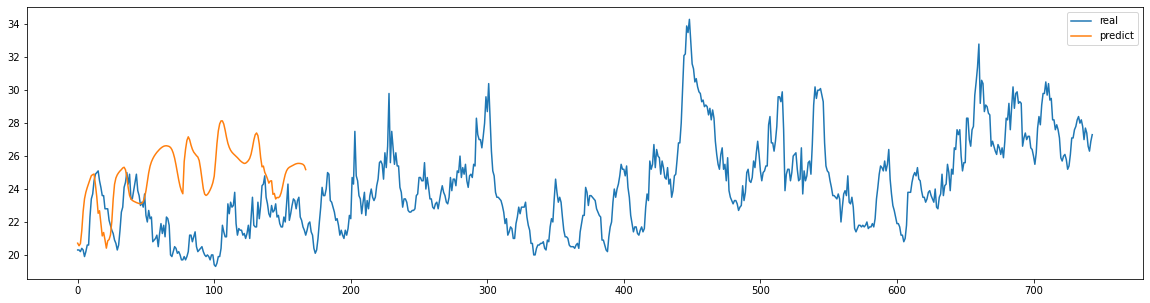

In [57]:
# 과소적합됨을 알 수 있다. 변수로 사용할 경우 Noise가 될 가능성이 커 제외한다.
import matplotlib.pyplot as plt

s_list = [7]
real = kma_jeju.query('year == 2020 and month in @s_list')['기온'].to_numpy()
result = df_test["value"].iloc[-24*7:].to_numpy()

# real = min_max_scaler.inverse_transform(real.reshape(-1,1)).reshape(-1)
# result = min_max_scaler.inverse_transform(result.reshape(-1,1)).reshape(-1)

plt.figure(figsize=(20,5))
plt.plot(real, label="real")
plt.plot(result, label="predict")
plt.legend()
plt.show()